# **1. 모델 설계**

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

[1728296648.457360] [workspace-ykmopma8i7ss-0:1487 :f]        vfs_fuse.c:281  UCX  ERROR inotify_add_watch(/tmp) failed: No space left on device
cuda:0


데이터 다운: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs

In [2]:
import os

root_path = '/root/projects/segmentation/cityscapes_data'

data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

print(len(train_fns), len(val_fns))

2975 500


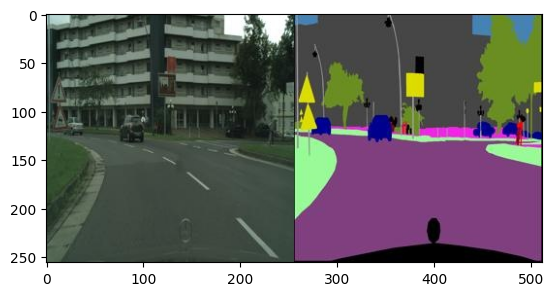

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [4]:
import numpy as np
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)

(1000, 3)


In [5]:
from sklearn.cluster import KMeans
num_classes = 10
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

In [6]:
def split_image(image) :
   image = np.array(image)
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label

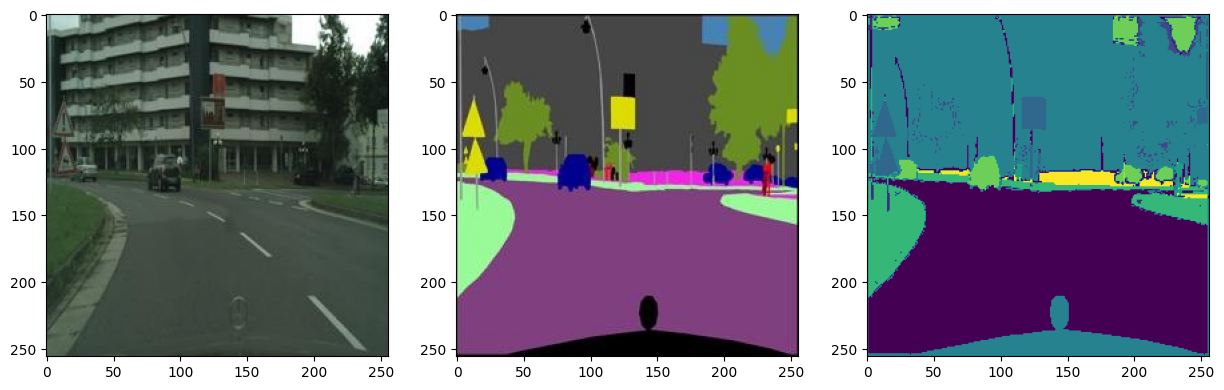

In [7]:
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model

  def __len__(self) :
    return len(self.image_fns)

  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class

  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label

  def transform(self, image) :
    transform_ops = transforms.Compose([
      			transforms.ToTensor(),
                        transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


In [29]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        # Define encoder blocks (conv_block) with downsampling
        self.encoder1 = self.conv_block(3, 64)  
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.encoder4 = self.conv_block(256,512)
        self.pool4 = nn.MaxPool2d(2)

        self.Bottleneck = self.conv_block(512,1024)

        # Define decoder blocks (conv_block) with upsampling
        self.upconv4 = nn.ConvTranspose2d(1024,512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder4 = self.conv_block(1024, 512)  # Remember: skip connection from encoder

        self.upconv3 = nn.ConvTranspose2d(512,256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder3 = self.conv_block(512, 256)  # Remember: skip connection from encoder

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder2 = self.conv_block(256, 128)  # Remember: skip connection from encoder

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder1 = self.conv_block(128, 64)

        # Output layer (1x1 conv)
        self.output_layer = nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1)    

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        return block

    def forward(self, X):
        # Encoder path
        enc1 = self.encoder1(X)            # [3, 256, 256] -> [64, 256, 256]
        enc2 = self.encoder2(self.pool1(enc1))  # [64, 256, 256] -> [128, 128, 128]
        enc3 = self.encoder3(self.pool2(enc2))  # [64, 256, 256] -> [128, 128, 128]
        enc4 = self.encoder4(self.pool3(enc3))  # [64, 256, 256] -> [128, 128, 128]


        # Bottleneck
        Bottleneck = self.Bottleneck(self.pool4(enc4))  # [128, 128, 128] -> [256, 64, 64]

        # Decoder path
        dec4 = self.upconv4(Bottleneck)  # Upsample [256, 64, 64] -> [128, 128, 128]
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection from encoder2
        dec4 = self.decoder4(dec4)       # [256, 128, 128] -> [128, 128, 128]
        
        dec3 = self.upconv3(dec4)  # Upsample [256, 64, 64] -> [128, 128, 128]
        dec3 = torch.cat((dec3, enc3), dim=1)  # Skip connection from encoder2
        dec3 = self.decoder3(dec3)       # [256, 128, 128] -> [128, 128, 128]

        dec2 = self.upconv2(dec3)  # Upsample [256, 64, 64] -> [128, 128, 128]
        dec2 = torch.cat((dec2, enc2), dim=1)  # Skip connection from encoder2
        dec2 = self.decoder2(dec2)       # [256, 128, 128] -> [128, 128, 128]

        dec1 = self.upconv1(dec2)        # Upsample [128, 128, 128] -> [64, 256, 256]
        dec1 = torch.cat((dec1, enc1), dim=1)  # Skip connection from encoder1
        dec1 = self.decoder1(dec1)       # [128, 256, 256] -> [64, 256, 256]

        # Output layer: [64, 256, 256] -> [num_classes, 256, 256]
        output_out = self.output_layer(dec1)

        return output_out

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

model = UNet(num_classes=num_classes)
data_loader = DataLoader(dataset, batch_size = 4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape)
print(Y.shape)

500 125
torch.Size([4, 3, 256, 256])
torch.Size([4, 256, 256])


In [31]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# **2. 모델 학습**

In [32]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 하이퍼파라미터 자율설정

batch_size = 32

epochs = 50
lr = 1e-4

dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

model = UNet(num_classes = num_classes).to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))

100%|██████████| 50/50 [1:41:31<00:00, 121.83s/it]


In [33]:
print(len(epoch_losses))  
print(epoch_losses)

50
[1.1097262027443096, 0.7154612598880645, 0.6383865212881437, 0.5882139923751996, 0.5529121304711988, 0.529445062081019, 0.509024574551531, 0.4904583490663959, 0.4754955146902351, 0.46179832502077983, 0.4478028525588333, 0.43566571352302386, 0.4258155300412127, 0.41470473011334735, 0.406761033240185, 0.39467419027000344, 0.38127994537353516, 0.3713555634021759, 0.36307412818554907, 0.359973100244358, 0.35185532255839275, 0.34361630966586454, 0.3337296374062056, 0.3256009897237183, 0.3185513612403664, 0.31219740692646275, 0.3060351938650172, 0.2958170048972612, 0.2901739415622527, 0.28670699782268977, 0.2792371937664606, 0.2731411026049686, 0.26392185479722996, 0.2556434155151408, 0.24945004444609406, 0.24526891865397013, 0.23979314232385288, 0.23555469512939453, 0.23102752239473404, 0.2325670845726485, 0.23281909461303424, 0.22971592394895451, 0.2233621394762429, 0.2178808149471078, 0.21212858185973218, 0.20704759368973394, 0.2038683008442643, 0.20063939386157578, 0.19845842433873043

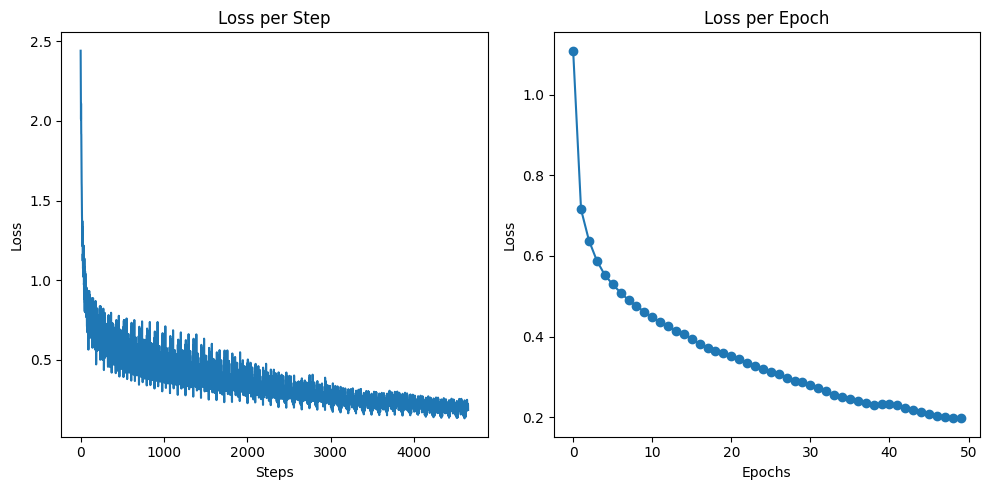

In [34]:
##TODO
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))


# Plot step-wise losses on the first subplot
axes[0].plot(step_losses, label='Step Losses')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss per Step')

# Plot epoch-wise losses on the second subplot
axes[1].plot(epoch_losses, label='Epoch Losses', marker='o', linestyle='-')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss per Epoch')

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
model_name = "UNet.pth"
torch.save(model.state_dict(), root_path + model_name)

# **3. 모델 평가**

In [36]:
model_path = root_path + model_name
model_ = UNet(num_classes = num_classes).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [37]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


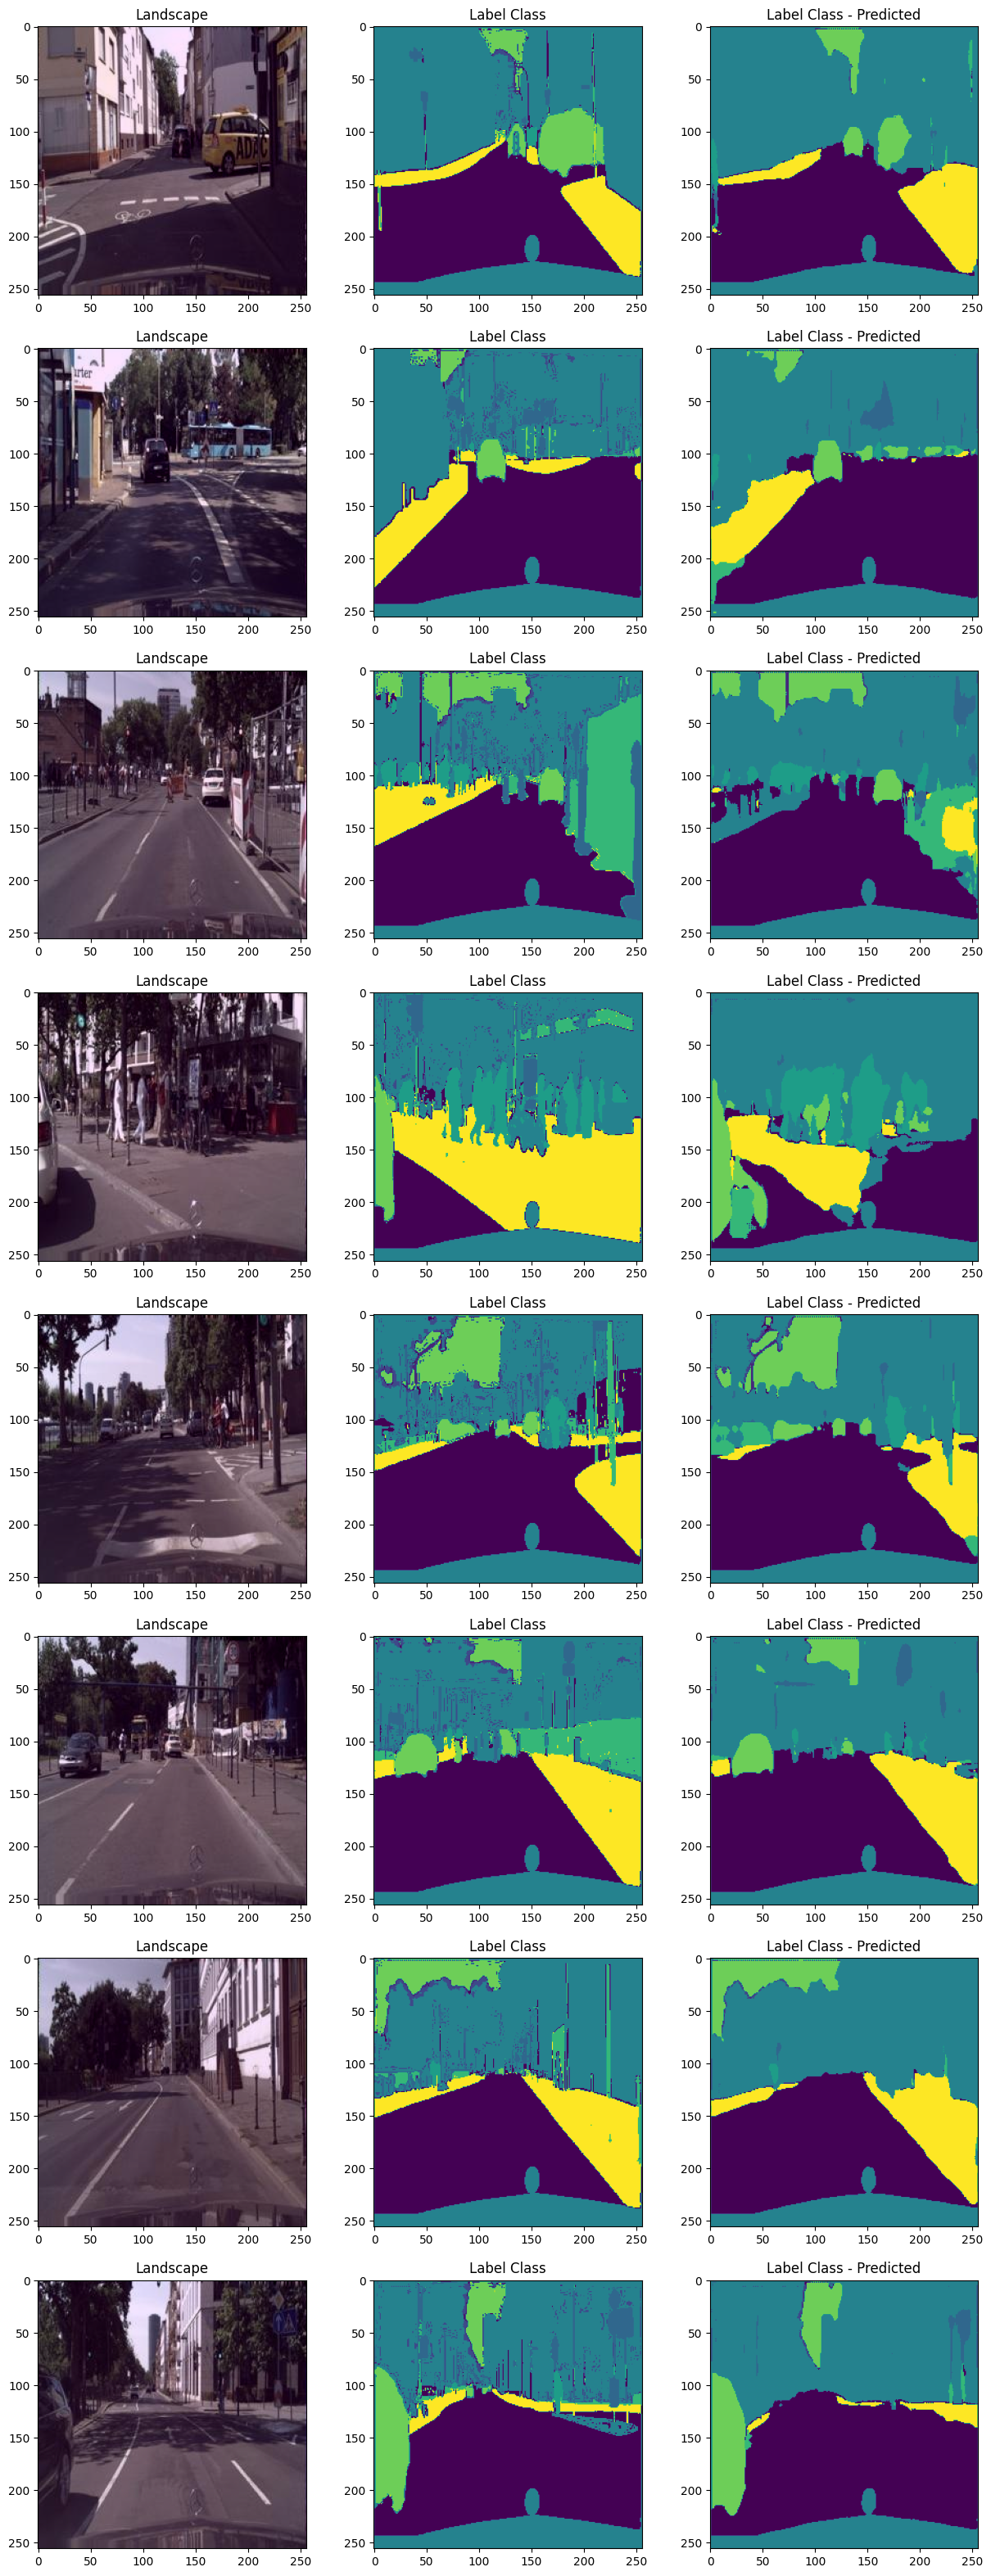

In [38]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

iou_scores = []

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # IOU score
    intersection = np.logical_and(label_class, label_class_predicted)
    union = np.logical_or(label_class, label_class_predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

# **4. IoU Score**

In [39]:
##TODO

iou_scores = []

for i in range(test_batch_size):
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    # Calculate IoU for each class
    num_classes = num_classes  # Set this to the number of classes in your segmentation task
    iou_per_class = []

    for cls in range(num_classes):
        # Create masks for the current class in both ground truth and prediction
        label_mask = label_class == cls
        pred_mask = label_class_predicted == cls

        # Intersection and union for the class
        intersection = np.logical_and(label_mask, pred_mask).sum()
        union = np.logical_or(label_mask, pred_mask).sum()

        if union == 0:
            iou_per_class.append(np.nan)  # If there's no ground truth/prediction for this class, skip it
        else:
            iou_per_class.append(intersection / union)

    # Mean IoU for this image
    mean_iou = np.nanmean(iou_per_class)
    iou_scores.append(mean_iou)

# Print the mean IoU for the batch
mean_iou_batch = np.mean(iou_scores)

print(f"{mean_iou_batch:0.4f}")

# IoU score 계산하기 에이 이건 쉽다 -> 안 쉬워!!!!

0.3381
